In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import sys
from importlib import reload
from pathlib import Path
import scanpy as sc
from pylab import rcParams
from matplotlib.patches import Patch
import re
import seaborn as sns
import glob
import matplotlib
from scipy.stats import zscore

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import scvelo as scv
scv.logging.print_version()


scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params('scvelo')  # for beautified visualization

%matplotlib inline

Running scvelo 0.2.2 (python 3.8.3) on 2021-04-12 12:31.


In [2]:
def adata_louvain_name_convert(inputAdata, orderDf, louvainNewOrdered, louvainOldOrdered):
    inputAdata.obs["louvain_celltype"] = ["%s_%s"%(x,y) for index, (x,y) in enumerate(zip(inputAdata.obs['louvain'], inputAdata.obs['cell_type']))]
    inputAdata.obs["celltype_general"] = [x[0] for x in inputAdata.obs['cell_type']]
    
    #--- Match old & new louvain levels
    inputAdata.obs['louvain_old'] = inputAdata.obs['louvain']
    inputAdata.uns['louvain_old_colors'] = inputAdata.uns['louvain_colors']
    inputAdata.obs['louvain'] = [ louvainNewOrdered[louvainOldOrdered.index(int(x))] for x in inputAdata.obs['louvain'] ]
    category_order = orderDf.sort_values('louvain')['louvain_new_label'].tolist()
    category_order = [x for x in category_order if x in np.unique(inputAdata.obs['louvain'])]
    inputAdata.obs['louvain'] = pd.Categorical(inputAdata.obs['louvain'].tolist(), categories=category_order) # The key is to set categories according to original order...

    inputAdata.obs['Infection type'] = [ 'Armstrong' if 'A' in x else 'Clone13' if 'C' in x else 'Naive' for x in inputAdata.obs['cell_type']]
    inputAdata.obs['cell_id'] = inputAdata.obs.index.tolist()

In [3]:
###----- Get dir & load / reload packages
try:
    code_dir
except NameError:
    print("Start")
    code_dir = os.getcwd()
    base_dir = code_dir.replace("/plotting_codes","")
    tools_dir = base_dir + "/tools"

    sys.path.insert(1, tools_dir)
    import sc_addons
    import sc_pl_addons
else:
    print("Reload")
    reload(sc_addons)
    reload(sc_pl_addons)

Start


In [4]:
## ----- Setup working dir
sp_name = "0_Acute-Chronic"
analysis_name = ["0", "resampled"] 

wk_dir = base_dir + "/9_Figures/%s/%s_%s/scVelo"%(sp_name, analysis_name[0], analysis_name[1])
Path(wk_dir).mkdir(parents=True, exist_ok=True)
os.chdir(wk_dir)

print(sp_name)

0_Acute-Chronic


In [5]:
###----- old - new cluster names
order_file ='%s/%s/2_scVelo'%(base_dir, sp_name) + '/%s_scVelo_out_%sNoDyn/pt_ordered_cluster_avg.csv'%(analysis_name[0], analysis_name[1])
order_df = pd.read_csv(order_file)
louvain_new_ordered = order_df['louvain_new_label'].tolist()
louvain_old_ordered = order_df['louvain'].tolist()

In [6]:
resampled_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/0_scVelo_out_resampled/0_Acute-Chronic_scVelo_postPT.h5ad'
adata = scv.read(resampled_h5ad)
adata_louvain_name_convert(adata, order_df, louvain_new_ordered, louvain_old_ordered)

if True:
    act_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/1_scVelo_out_ACTonly/0_Acute-Chronic_scVelo_postPT.h5ad'
    adata_act = scv.read(act_h5ad)
    
    act_arm_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/2_scVelo_out_actARMonly/0_Acute-Chronic_scVelo_postPT.h5ad'
    adata_act_arm = scv.read(act_arm_h5ad)

    act_cl13_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/3_scVelo_out_actCL13only/0_Acute-Chronic_scVelo_postPT.h5ad'
    adata_act_cl13 = scv.read(act_cl13_h5ad)

    arm_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/2_scVelo_out_ARMonly/0_Acute-Chronic_scVelo_postPT.h5ad'
    adata_arm = scv.read(arm_h5ad)

    cl13_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/3_scVelo_out_CL13only/0_Acute-Chronic_scVelo_postPT.h5ad'
    adata_cl13 = scv.read(cl13_h5ad)
    
    adata_louvain_name_convert(adata_act, order_df, louvain_new_ordered, louvain_old_ordered)
    adata_louvain_name_convert(adata_act_arm, order_df, louvain_new_ordered, louvain_old_ordered)
    adata_louvain_name_convert(adata_act_cl13, order_df, louvain_new_ordered, louvain_old_ordered)
    adata_louvain_name_convert(adata_arm, order_df, louvain_new_ordered, louvain_old_ordered)
    adata_louvain_name_convert(adata_cl13, order_df, louvain_new_ordered, louvain_old_ordered)
    
    adata_act.obs['velocity_pseudotime'] = adata.obs['velocity_pseudotime'][adata_act.obs.index.tolist()]
    adata_act_arm.obs['velocity_pseudotime'] = adata.obs['velocity_pseudotime'][adata_act_arm.obs.index.tolist()]
    adata_act_cl13.obs['velocity_pseudotime'] = adata.obs['velocity_pseudotime'][adata_act_cl13.obs.index.tolist()]
    adata_arm.obs['velocity_pseudotime'] = adata.obs['velocity_pseudotime'][adata_arm.obs.index.tolist()]
    adata_cl13.obs['velocity_pseudotime'] = adata.obs['velocity_pseudotime'][adata_cl13.obs.index.tolist()]

In [7]:
paga_xmax, paga_ymax = np.amax(adata.obsm['paga'], axis=0)
paga_xmin, paga_ymin = np.amin(adata.obsm['paga'], axis=0)
paga_dx, paga_dy = paga_xmax - paga_xmin, paga_ymax - paga_ymin
paga_xmax, paga_xmin = paga_xmax + paga_dx*0.1, paga_xmin - paga_dx*0.1
paga_ymax, paga_ymin = paga_ymax + paga_dy*0.1, paga_ymin - paga_dy*0.1

In [80]:
### Intersect chromatin regulators & TF & cell surface receptors
surface_df = pd.read_csv('https://raw.githubusercontent.com/Yolanda-HT/SurfaceMarkers_Cytokines/master/2_compiled/MM_MARKERS.csv')
surface_genes = surface_df['gene_name'].tolist()
crf_df = pd.read_csv('https://raw.githubusercontent.com/ScrippsPipkinLab/CRF_Screen/master/Ref/CRF_all.csv')
crf_genes = crf_df['gene_name'].tolist() + [x for x in crf_df['Alternative'].tolist() if str(x) != 'nan']
tf_df = pd.read_csv('https://raw.githubusercontent.com/Yolanda-HT/TFclassDataCollection/master/Ravasi_TF.csv')
tf_genes = tf_df['symbol'].tolist()
all_genes = list(set(surface_genes + crf_genes + tf_genes))

### Gene signature genes
gs_plot_use_file = '/media/pipkin/ROCKET-PRO/T_cell_signature_Reference/Y_annotated/anno_plotuse_gs_20200928.csv'
gs_plot_use_df = pd.read_csv(gs_plot_use_file)
gs_use = gs_plot_use_df[gs_plot_use_df['plot_use'].notnull()]['gs_name'].tolist()

gs_file = '/media/pipkin/ROCKET-PRO/T_cell_signature_Reference/X_GeneSignatures_mm/all_mouse_T_cell_signatures.csv'
gs_df = pd.read_csv(gs_file)
gs_df_use = gs_df[[True if x in gs_use else False for x in gs_df['gs_name']]]
genes_use = list(set(gs_df_use['gene_symbol'].tolist()))

genes_use = [i for i in genes_use if i in all_genes]
#genes_use = all_genes

In [9]:
out_dir = wk_dir + '/trajectory_drivers'
Path(out_dir).mkdir(parents=True, exist_ok=True)

out_dir = wk_dir + '/likelihood_genes_drivers'
Path(out_dir).mkdir(parents=True, exist_ok=True)

out_dir = wk_dir + '/pairwise_transition_prob'
Path(out_dir).mkdir(parents=True, exist_ok=True)

In [10]:
def extract_avg(adata_use, gene_list, layer):
    df = pd.DataFrame(adata_ij.layers[layer])
    df.columns = adata_use.var.index
    return(df[gene_list].mean(axis=0).tolist())

# Calculate average Ms Mu Velocity for drivers

In [11]:
drivers_dir = wk_dir + '/likelihood_genes'
drivers_files = glob.glob("%s/*.csv"%drivers_dir)

In [12]:
drivers_all = []
for i in drivers_files:
    i_df = pd.read_csv(i, index_col=0)
    drivers_all += i_df.index.tolist()

drivers_all = set(drivers_all)
len(drivers_all)

752

In [190]:
def layer_group_average_slt_genes(adata_use, layer_use, genes_use, group_use, group_order, key):
    df = pd.DataFrame(adata_use.layers[layer_use])
    df.columns = adata_use.var.index
    genes_use = [x for x in genes_use if x in df.columns.tolist()]
    df = df[genes_use]
    df[group_use] = adata_use.obs[group_use].tolist()
    df_mean = df.groupby(group_use).mean().T
    group_order_use = [x for x in group_order if x in df_mean.columns.tolist()]
    df_mean = df_mean[group_order_use]
    df_mean.columns = ["%s_%s"%(key, x) for x in df_mean.columns]
    return(df_mean)

In [101]:
all_drivers_ms_df = layer_group_average_slt_genes(adata, 'Ms', drivers_all, 'louvain', louvain_new_ordered, 'All')
all_drivers_mu_df = layer_group_average_slt_genes(adata, 'Mu', drivers_all, 'louvain', louvain_new_ordered, 'All')
all_drivers_v_df = layer_group_average_slt_genes(adata, 'velocity', drivers_all, 'louvain', louvain_new_ordered, 'All')

arm_drivers_ms_df = layer_group_average_slt_genes(adata_act_arm, 'Ms', drivers_all, 'louvain', louvain_new_ordered, 'Act-Arm')
arm_drivers_mu_df = layer_group_average_slt_genes(adata_act_arm, 'Mu', drivers_all, 'louvain', louvain_new_ordered, 'Act-Arm')
arm_drivers_v_df = layer_group_average_slt_genes(adata_act_arm, 'velocity', drivers_all, 'louvain', louvain_new_ordered, 'Act-Arm')

cl13_drivers_ms_df = layer_group_average_slt_genes(adata_act_cl13, 'Ms', drivers_all, 'louvain', louvain_new_ordered, 'Act-Cl13')
cl13_drivers_mu_df = layer_group_average_slt_genes(adata_act_cl13, 'Mu', drivers_all, 'louvain', louvain_new_ordered, 'Act-Cl13')
cl13_drivers_v_df = layer_group_average_slt_genes(adata_act_cl13, 'velocity', drivers_all, 'louvain', louvain_new_ordered, 'Act-Cl13')


###----- Merge and save
if False:
    all_drivers_ms_df = all_drivers_ms_df.join(arm_drivers_ms_df).join(cl13_drivers_ms_df)
    all_drivers_mu_df = all_drivers_mu_df.join(arm_drivers_mu_df).join(cl13_drivers_mu_df)
    all_drivers_v_df = all_drivers_v_df.join(arm_drivers_v_df).join(cl13_drivers_v_df)

    new_colnames_ordered = []
    for i in louvain_new_ordered:
        new_colnames_ordered += ['All_%s'%i, 'Act-Arm_%s'%i, 'Act-Cl13_%s'%i]

    all_drivers_ms_df = all_drivers_ms_df[[x for x in new_colnames_ordered if x in all_drivers_ms_df.columns.tolist()]]
    all_drivers_mu_df = all_drivers_mu_df[[x for x in new_colnames_ordered if x in all_drivers_mu_df.columns.tolist()]]
    all_drivers_v_df = all_drivers_v_df[[x for x in new_colnames_ordered if x in all_drivers_v_df.columns.tolist()]]

    all_drivers_ms_df.to_csv("%s/all_drivers_Ms.csv"%drivers_dir)
    all_drivers_mu_df.to_csv("%s/all_drivers_Mu.csv"%drivers_dir)
    all_drivers_v_df.to_csv("%s/all_drivers_Velocity.csv"%drivers_dir)

*Velocity Z Score for each cluster*

In [141]:
type_dict = {'All': all_drivers_v_df, 'Act-Arm': arm_drivers_v_df, 'Act-Cl13': cl13_drivers_v_df}

key_v_genes_df = pd.DataFrame({'index':list(range(100))}).set_index('index')
for type_key, v_df in type_dict.items():
    
    v_df = v_df.dropna(axis=0)
    
    for i in v_df.columns:
        top_v_genes = v_df.sort_values([i], ascending=False)[:50].index.tolist()

        v_df_z = v_df.T.apply(zscore).T
        top_v_z_genes = v_df_z.sort_values([i], ascending=False)[:50].index.tolist()
        
        key_v_genes_df[i] = pd.Series(list( set(top_v_genes) & set(top_v_z_genes) ))
key_v_genes_df.to_csv("%s/all_drivers_Velocity_keyGenes.csv"%drivers_dir)

# Driver gene heatmap for each trajectories

In [14]:
drivers_heatmap_dir = wk_dir + '/likelihood_genes_heatmap'
Path(drivers_heatmap_dir).mkdir(parents=True, exist_ok=True)

In [15]:
adata.obs

,initial_size_spliced,initial_size_unspliced,initial_size,n_counts,scanpy_paga,cell_type,louvain,dpt_pseudotime,velocity_self_transition,root_cells,end_points,velocity_pseudotime,louvain_celltype,celltype_general,louvain_old,Infection type,cell_id
Exp391:AAACGAAGTCAAAGTAx,13553,6195,13553.0,2955.693848,Use,A5P,P3,0.950097,0.180602,0.0,5.877838e-07,0.612657,1_A5P,A,1,Armstrong,Exp391:AAACGAAGTCAAAGTAx
Exp391:AAACGAATCGACCATAx,10150,3023,10150.0,2779.387695,Use,A5T,P6,0.935370,0.057014,0.0,2.294428e-06,0.718390,5_A5T,A,5,Armstrong,Exp391:AAACGAATCGACCATAx
Exp391:AAAGGATCAATACAGAx,5723,1499,5723.0,2802.680420,Use,C5P,P5,0.972601,0.189438,0.0,2.051111e-07,0.616503,4_C5P,C,4,Clone13,Exp391:AAAGGATCAATACAGAx
Exp391:AAAGAACTCGATACGTx,9857,3445,9857.0,2802.789307,Use,C5P,P7,0.887958,0.189524,0.0,1.176717e-06,0.757695,7_C5P,C,7,Clone13,Exp391:AAAGAACTCGATACGTx
Exp391:AAACCCATCCGACAGCx,1920,1137,1920.0,1907.016479,Use,C8P,P8,0.939535,0.086418,0.0,2.746603e-03,0.867200,8_C8P,C,8,Clone13,Exp391:AAACCCATCCGACAGCx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Exp391:TTTGGTTTCCGCGATGx,3360,2084,3360.0,2292.282959,Use,A8P,P10,0.947714,0.013675,0.0,1.488258e-01,0.948867,2_A8P,A,2,Armstrong,Exp391:TTTGGTTTCCGCGATGx
Exp391:TTTGGAGAGAGTGTTAx,5636,1436,5636.0,2674.750488,Use,C8P,P3,0.983472,0.069240,0.0,6.910402e-07,0.586007,1_C8P,C,1,Clone13,Exp391:TTTGGAGAGAGTGTTAx
Exp391:TTTGATCTCGAGTTGTx,1933,1233,1933.0,1942.812256,Use,C8P,P6,0.924697,0.040571,0.0,3.173492e-03,0.921013,5_C8P,C,5,Clone13,Exp391:TTTGATCTCGAGTTGTx
Exp391:TTTGGTTAGGGTCAACx,5313,2570,5313.0,2589.668701,Use,C8P,P8,0.942617,0.116983,0.0,4.434932e-07,0.786743,8_C8P,C,8,Clone13,Exp391:TTTGGTTAGGGTCAACx


In [195]:
trajectory_clusters = [['P2', 'P5', 'P3'], ['P2', 'P5', 'P6'], ['P2', 'P7', 'P9', 'P10'], ['P2', 'P4', 'P9','P10'], ['P2','P6','P8','P9','P10']]
# trajectory_clusters = [['P2', 'P5', 'P3']] # Test only

for subset_clusters in trajectory_clusters:
    subset_name = drivers_heatmap_dir + '/' + "-".join(subset_clusters)
    adata_subset = adata[[True if x in subset_clusters else False for x in adata.obs['louvain'] ]]
    order_dict = {subset_clusters[x]:x*0.1 for x in range(len(subset_clusters))}
    adata_subset.obs['louvain_order'] = [order_dict[x] for x in adata_subset.obs['louvain']]

    layer_use_dict = {'Ms':'viridis', 'Mu':'viridis', 'velocity':'icefire'}
    celltype_use_dict = {'Arm': ['A'], 'Cl13': ['C'], 'AllAct':['A','C']}
    
    # layer_use_dict = {'Ms':'viridis'} # Test only
    # celltype_use_dict = {'Arm': ['A']} # Test only

    for layer_use, layer_use_col in layer_use_dict.items():
        for celltype_name, celltype_use in celltype_use_dict.items():
            adata_plot = adata_subset.copy()
            adata_plot = adata_plot[[True if x in celltype_use else False for x in adata_plot.obs['celltype_general']]]
            if layer_use == 'velocity':
                not_na_axis0 = [ not np.isnan(x) for x in adata_plot.layers['velocity'].sum(axis=0)]
                adata_plot = adata_plot[:, not_na_axis0]
            hm = scv.pl.heatmap(adata_plot, var_names=list(drivers_all), sortby='louvain_order', col_color='louvain', layer=layer_use, show=False,color_map=layer_use_col)
            hm.savefig(subset_name +  "_" + celltype_name +  "_" + layer_use + '.png')
            
            # Cell type average value
            mean_df = layer_group_average_slt_genes(adata_plot, layer_use, list(drivers_all), 'louvain', subset_clusters, celltype_name)
            mean_df = mean_df.loc[hm.data.index.tolist()]
            
            mean_df.to_csv(subset_name +  "_" + celltype_name +  "_" + layer_use + '.csv')
            plt.close()

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


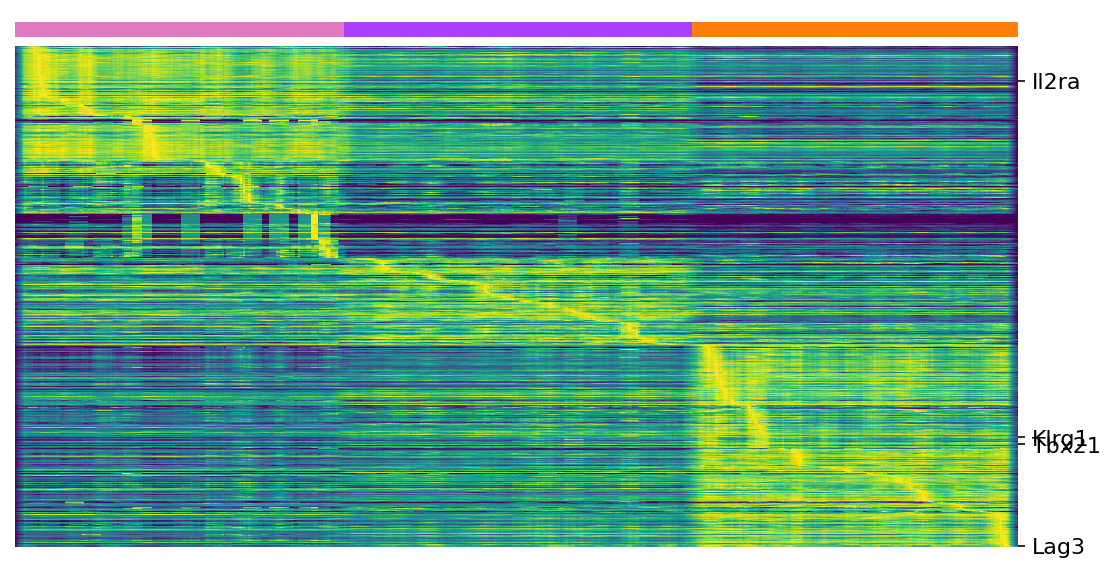

In [144]:
hm = scv.pl.heatmap(adata_plot, var_names=list(drivers_all), sortby='louvain_order', col_color='louvain', layer=layer_use, show=False,color_map=layer_use_col)

label_list = ['Il2ra','Tbx21','Klrg1','Lag3']
label_list = [x for x in hm.data.index if x in label_list]
label_loc = [hm.data.index.tolist().index(x) - 0.5 for x in label_list]

ax = hm.ax_heatmap
ax.yaxis.set_ticks(label_loc)
ax.set_yticklabels(original_ticklabels)

hm
plt.show()